## Calculate statistcs
1. Find valid tracks within Houston region
2. Calculate statistics including: radius, lifetime, start and end time, start and end status, cell location, maxrange_flag (touch the boudary), maxdbz, maxdbz height

In [1]:
%load_ext autoreload
%autoreload 2
import os
from glob import glob
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
import matplotlib as mpl
import cartopy.crs as ccrs
from radar_util import radar_util
%config InlineBackend.figure_format='retina'

In [2]:
# Parameters
projectdir = '/rcfs/projects/windpower_wfip2uq/liuy351/Tracer'
radar_lat = 29.47194480896
radar_lon = -95.0788879394531
figdir = './radar_fig'
os.makedirs(figdir, exist_ok=True)

# Controlling variables
flag_mkdata=True
year1 = 2005
year2 = 2017

In [3]:
data = {}
# load tracks stats
if year2 is None:
    stats  = xr.open_dataset(f'{projectdir}/trackstats_concatenated/{year1}_valid.nc')
    stats2 = pd.read_csv(f'{projectdir}/trackstats_concatenated/{year1}.stats.csv')
else:
    stats  = xr.open_dataset(f'{projectdir}/trackstats_concatenated/{year1}-{year2}_valid.nc')
    stats2 = pd.read_csv(f'{projectdir}/trackstats_concatenated/{year1}-{year2}.stats.csv')
ntracks = stats.dims['tracks']

data['ntracks'] = ntracks
print(stats)
print(data)
data = radar_util.get_cell_statistics(data, stats)

hour_bin, hist_starthour_LT  = radar_util.count_tracks_by_diurnal_timing(stats2)


<xarray.Dataset>
Dimensions:                  (tracks: 206580, times: 100)
Coordinates:
  * tracks                   (tracks) int64 71151 71152 71153 ... 277742 277743
  * times                    (times) int64 0 1 2 3 4 5 6 ... 94 95 96 97 98 99
Data variables: (12/37)
    track_duration           (tracks) int32 ...
    base_time                (tracks, times) datetime64[ns] ...
    meanlat                  (tracks, times) float32 ...
    meanlon                  (tracks, times) float32 ...
    area                     (tracks, times) float32 ...
    cloudnumber              (tracks, times) float64 ...
    ...                       ...
    start_split_tracknumber  (tracks) float64 ...
    start_split_timeindex    (tracks) float64 ...
    start_split_cloudnumber  (tracks) float64 ...
    end_merge_tracknumber    (tracks) float64 ...
    end_merge_timeindex      (tracks) float64 ...
    end_merge_cloudnumber    (tracks) float64 ...
Attributes:
    Title:                 Statistics of ea

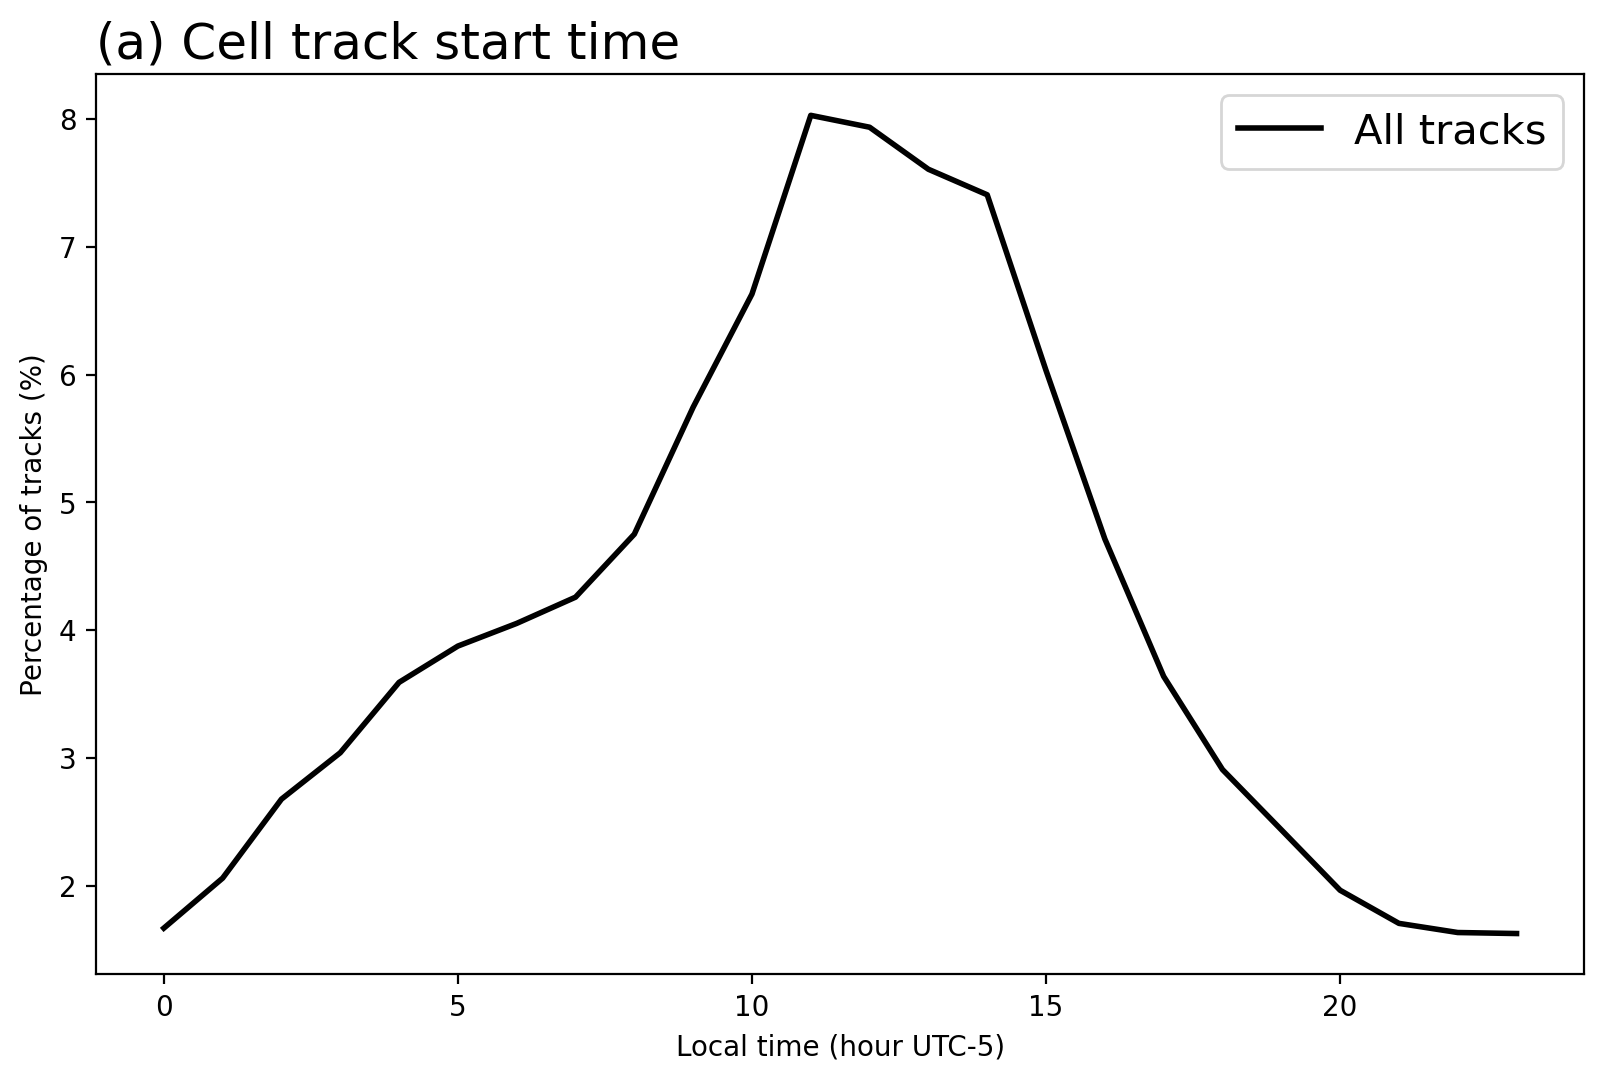

<Figure size 800x500 with 0 Axes>

In [4]:
def plot_ts(*lines, **kwargs):
    '''
    lines: (x, y, kwargs)
    '''
    mpl.rcParams['font.size'] = 15
    mpl.rcParams['font.family'] = 'Helvetica'  

    if (fig:=kwargs.get('fig')) is None:  
        fig = plt.figure(figsize=(8, 5))
    if (ax:=kwargs.get('ax')) is None:  ax = plt.axes()
    ax.set_axis_on()
    
    default_line_kw = dict()
    cs = []
    for line in lines:
        x, y, kw = line
        default_line_kw.update(kw)
        _cs, = ax.plot(x, y, **default_line_kw)
        cs.append(cs)
        
    if (title:=kwargs.get('title')) is not None: 
        default_title_kwargs = dict(loc='left')
        default_title_kwargs.update(kwargs.get('title_kwargs', {}))
        ax.set_title(title, **default_title_kwargs)
    if (xlabel:=kwargs.get('xlabel')) is not None: 
        default_xlabel_kwargs = dict()
        default_xlabel_kwargs.update(kwargs.get('xlabel_kwargs', {}))
        ax.set_xlabel(xlabel, **default_xlabel_kwargs)    
    if (ylabel:=kwargs.get('ylabel')) is not None: 
        default_ylabel_kwargs = dict()
        default_ylabel_kwargs.update(kwargs.get('ylabel_kwargs', {}))
        ax.set_ylabel(ylabel, **default_ylabel_kwargs) 
    if (kwargs.get('time_xaxis', False)):
        import matplotlib.dates as mdates
        major_locator = mdates.DayLocator()    
        ax.xaxis.set_major_formatter(mdates.DateFormatter('%d'))
        ax.xaxis.set_major_locator(mdates.DayLocator())
        ax.xaxis.set_minor_locator(mdates.DayLocator())
    if (kwargs.get('draw_grid', False)):
        default_grid_kwargs = dict(ls='--')
        default_grid_kwargs.update(kwargs.get('grid_kwargs', {}))
        ax.grid(**default_grid_kwargs)
    if (kwargs.get('draw_legend', False)):
        default_legend_kwargs = dict()
        default_legend_kwargs.update(kwargs.get('legend_kwargs', {}))
        ax.legend(**default_legend_kwargs)
    if (ylim:=kwargs.get('ylim')) is not None: ax.set_ylim(ylim)
    if (xlim:=kwargs.get('xlim')) is not None: ax.set_xlim(xlim)
    if (xticks:=kwargs.get('xticks')) is not None: ax.set_xticks(xticks)    
    return ax, cs
                                   
    
fig, ax = plt.subplots(1, 1, figsize=(8, 5), sharex=True, sharey=True)
plt.subplots_adjust(left=0.05, bottom=0.05, right=0.98, top=0.95, hspace=0.4, wspace=0.05)
ax, cs = plot_ts(
    (hour_bin, hist_starthour_LT, dict(c='k', lw=2, label='All tracks')),
    ax=ax,
    title=f'(a) Cell track start time',
    xlabel='Local time (hour UTC-5)',
    ylabel='Percentage of tracks (%)',
    draw_legend=True,
)


### Split the tracks based on SOM types

swaping bmu....


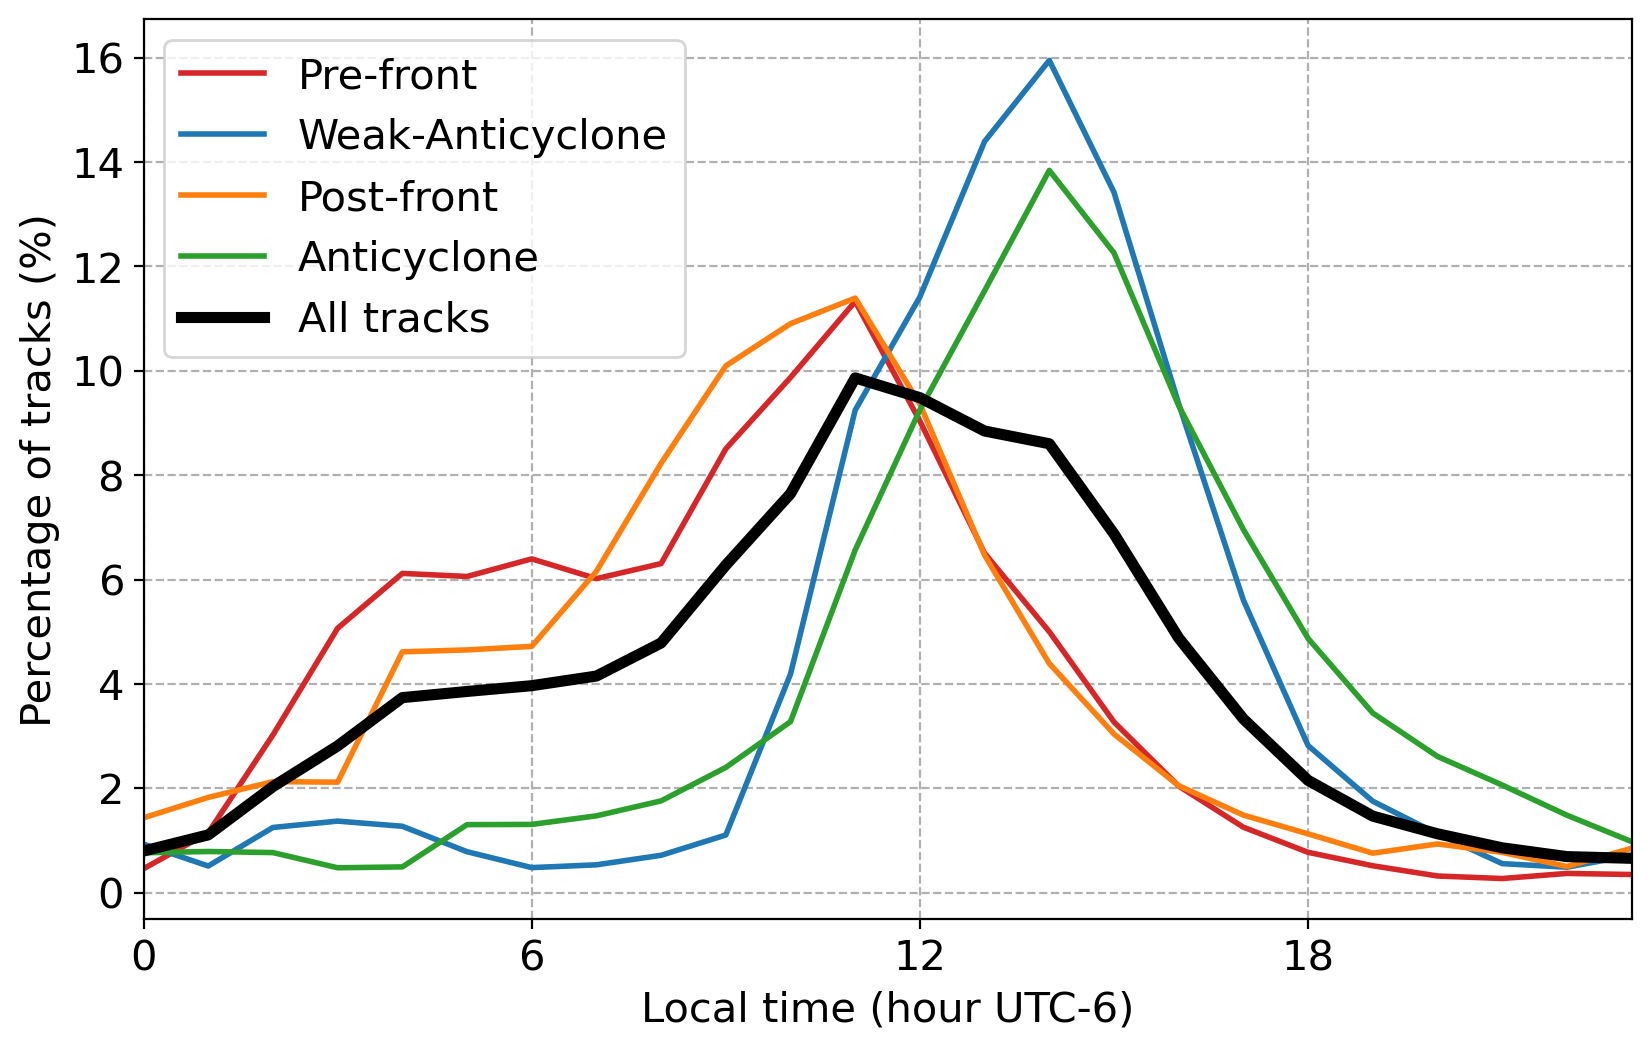

In [7]:
track_cluster = radar_util.calc_cell_cluster_som(stats2, season='JJA')
fig, ax = plt.subplots(1, 1, figsize=(8, 5), sharex=True, sharey=True)
plt.subplots_adjust(left=0.05, bottom=0.05, right=0.98, top=0.95, hspace=0.4, wspace=0.05)

x, y = [], []
color = ['tab:red', 'tab:blue', 'tab:orange', 'tab:green', 'k']
label = ['Pre-front', 'Weak-Anticyclone', 'Post-front', 'Anticyclone']
for som in np.arange(4):
    # _stats  = stats.sel(tracks=track_cluster[som])
    _stats2 = stats2.loc[stats2['tracks'].isin(track_cluster[som]),:]

    # Count tracks by diurnal timing
    _hour_bin, _hist_starthour_LT  = radar_util.count_tracks_by_diurnal_timing(_stats2)

    plot_ts(
        (_hour_bin, _hist_starthour_LT, dict(c=color[som], lw=2, label=label[som])),
        ax=ax,fig=fig,
    )
# all data in this season
_stats2 = stats2.loc[stats2['tracks'].isin(np.concatenate(track_cluster)),:]
_hour_bin, _hist_starthour_LT  = radar_util.count_tracks_by_diurnal_timing(_stats2)
plot_ts(
    (_hour_bin, _hist_starthour_LT, dict(c='k', lw=4, label=f'All tracks')),
    fig=fig, ax=ax,
    # title=f'Cell track start time',
    xlabel='Local time (hour UTC-6)',
    ylabel='Percentage of tracks (%)',
    draw_legend=True,
    draw_grid=True,
)
ax.set_xticks([0,6,12,18,24])
ax.set_xlim(0,23)
fig.savefig('paper/Figure12.pdf', bbox_inches='tight')
fig.savefig('paper/Figure12.png', format='png', bbox_inches='tight', dpi=300)
